___

Mahebub Aalam Khatri

Astron 321 Final Project

## Calculating the Period-Magnitude Relationship for Classical Cepheids to Find the Distance to the LMC

OGLE data downloaded from:
> https://www.astrouw.edu.pl/ogle/ogle4/OCVS/

In [2]:
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import uncertainties as unc
import uncertainties.unumpy as unp
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.ipac.irsa.irsa_dust import IrsaDust
import os

In [2]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


First, we convert the cepheid list provided by OGLE into a pandas dataframe and extract the Gaia-EDR3 IDs for cepheids that have I-band data, OGLE IDs, and oscillate in the first fundamental mode.

In [3]:
# read in the file and create a dataframe
# NOTE: in order to get colspecs to infer spacing correctly 
#       (especially for Gaia/OGLE IDs), I had to rearrange
#       some of the entries
df = pd.read_fwf('allGalCep.listID', colspecs="infer", skiprows=2, 
                names=['Source', 'Name', 'RA(2000.0)', 'Dec(2000.0)', 'RA[deg]', 
                'Dec[deg]', 'l[deg]', 'b[deg]', 'Mode(s)', 'P_F[day]', 'P_1O[day]', 
                'P_2O[day]', 'P_3O[day]', 'Bands', 'OGLE', 'OGLE-II', 'OGLE-III', 
                'OGLE-IV', 'ASAS', 'ASASSN-V', 'Gaia-EDR3', 'G[mag]'])

# make a data frame with all entries that have I-band data, 
# OGLE ID, GAIA ID, and oscillate in the first fundamental mode
dfI = df.loc[((df["Bands"] == "I") | (df["Bands"] == "VI")
        | (df["Bands"] == "BVI") | (df["Bands"] == "VIc"))
        & (df["OGLE"] != "-") & (df["Mode(s)"] == "F") 
        & (df["Gaia-EDR3"] != "-")]

# extract a list of Gaia IDs, OGLE IDs
gaiaIDs = dfI["Gaia-EDR3"].tolist()
ogleIDs = dfI["OGLE"].tolist()

# make an astropy table of gaiaIDs and corresponding ogleIDs
table = Table([gaiaIDs, ogleIDs], names=['GaiaEDR3', 'OGLE'])

Then we use the list of GAIA IDs to query the Gaia-EDR3 database for parallax and parallax error measurements and join them to the Pandas dataframe.
If we already have the data saved, we can skip right to reading the gaiaData.csv file.

In [9]:
job = Gaia.upload_table(upload_resource=table, table_name="cepheid_IDs")

Sending pytable.
Uploaded table 'cepheid_IDs'.


In [4]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

job = Gaia.launch_job("SELECT source_id, ra, dec, parallax, parallax_error FROM gaiaedr3.gaia_source g INNER JOIN user_mkhatri.cepheid_IDs c ON g.source_id = CAST(c.GaiaEDR3 AS bigint)")
r = job.get_results()
pdr = r.to_pandas()

In [ ]:
# convert GaiaID to int64 so we can merge
pdtable = table.to_pandas()
pdtable["GaiaEDR3"] = pdtable["GaiaEDR3"].astype("Int64")

gaia = pd.merge(pdtable, pdr, left_on="GaiaEDR3", right_on="source_id")

# delete repeated column with GaiaIDs
del gaia["source_id"]

In [6]:
# going to save the data because the Gaia website is gonna go down on Monday
gaia.to_csv("gaiaData.csv", index=False)

Now we can just load in the gaiaData.csv file instead of querying again:

In [4]:
gaia = pd.read_csv("gaiaData.csv")

Then we convert the parallax measurements and uncertainties to distances and distance uncertainties and add those as columns in our dataframe.

Since Gaia reports parallax in milliarcseconds, the usual equation $d=\frac{1\mathrm{pc}}{\pi''}$ for $\pi''$ in arcseconds becomes $d=\frac{1\mathrm{pc}}{\pi_{\mathrm{mas}}/1000}$ or equivalently: $$d=\frac{1\mathrm{pc}\cdot 1000}{\pi_{\mathrm{mas}}}$$

In [5]:
# adding distance column
gaia["distance_pc"] = 1000/gaia["parallax"]

# using the uncertainties package to add distance error column
parallax = gaia["parallax"].to_list()
parallax_error = gaia["parallax_error"].to_list()
distance_error = unp.std_devs(1000/unp.uarray((parallax, parallax_error)))
gaia["dist_error"] = distance_error

# filter out cepheids with distance error/distance > 0.1 and negative distances
mdf = gaia.loc[(gaia["dist_error"]/gaia["distance_pc"] < 0.1) & (gaia["distance_pc"] > 0)]
# NOTE: this drops the number of valid Cepheids from 1141 to just 101. Yikes :(
mdf

C:\Users\mmrsk\AppData\Local\Temp\ipykernel_17024\1126197335.py:7: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  distance_error = unp.std_devs(1000/unp.uarray((parallax, parallax_error)))
c:\Users\mmrsk\anaconda3\envs\ASTRON\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


,GaiaEDR3,OGLE,ra,dec,parallax,parallax_error,distance_pc,dist_error
4,3330259852538068608,OGLE-GD-CEP-1284,91.856108,11.151976,0.230497,0.021817,4338.444079,410.633183
6,3344381567567275392,OGLE-GD-CEP-0028,93.091510,13.636594,0.290342,0.025603,3444.217066,303.714379
10,3331279542194394240,OGLE-GD-CEP-0033,96.017277,11.708839,0.230745,0.021257,4333.793904,399.240151
13,3327281790934522752,OGLE-GD-CEP-0043,97.720723,9.673099,0.222357,0.017701,4497.274278,358.016914
17,3326443821335586816,OGLE-GD-CEP-0046,98.404924,9.203568,0.183142,0.015026,5460.242268,447.976422
...,...,...,...,...,...,...,...,...
1106,4320062347542878208,OGLE-GD-CEP-1544,290.889255,15.367826,0.293404,0.027282,3408.264936,316.920627
1121,4321755561092593920,OGLE-GD-CEP-1560,292.218457,16.688160,0.281604,0.022221,3551.092158,280.215552
1134,1825428480248517376,OGLE-GD-CEP-1575,293.565623,19.570660,0.213551,0.018342,4682.717310,402.201849
1138,1824511899869141120,OGLE-GD-CEP-1580,295.146314,19.285550,0.272804,0.016299,3665.633736,219.010202


Now that we have a dataframe with OGLE IDs and their corresponding distances, we can add in another column with their periods. However, we will first need to calculate their periods using their I-band lightcurves and Lomb-scargle. 
This is achieved in the following steps for each cepheid:
1) Extract the observation times and the magnitudes at those times for as two arrays. 
2) Use the astropy function 'LombScargle' to calculate the frequency to power relationship.
3) The corresponding frequency of the maximum of the power function is the best-fit period for that cepheid.
4) Add the calculated period to the corresponding cepheid in the data frame.
Repeat these steps for each cepheid in OGLE's galactic bulge and galactic disk data set to form the period luminosity relationship.

Let's test this method on just on Cepheid first:

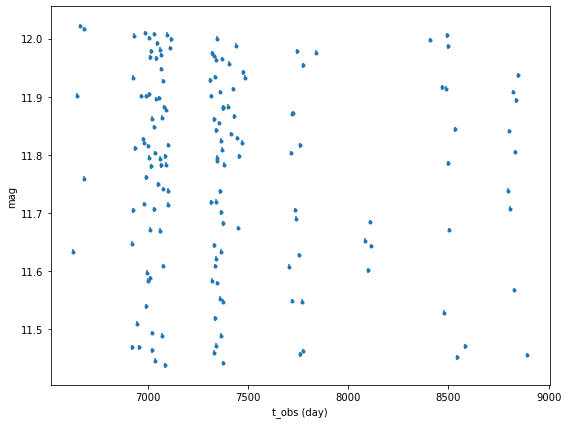

In [12]:
def convert_to_dataframe(file_path):
    return pd.read_fwf(file_path, colspecs=[(0,10),(11,17),(18,23)], names=["t_obs", "mag", "error"])

item = convert_to_dataframe('gd\I\OGLE-GD-CEP-0028.dat')
t_obs = item["t_obs"].to_list()
mag = item["mag"].to_list()
error = item["error"].to_list()

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.errorbar(t_obs, mag, yerr=error, fmt='.')
ax.set_ylabel('mag')
ax.set_xlabel('t_obs (day)')
fig.tight_layout()

> Focusing on just one cepheid in the bulge, we can see how the observation times are spread out. Now let's try to apply LombScargle to it...
(Making use of part of the code from the "BuildingLombScargle.ipynb" lab)

Calculated period: 3.5627792338570794 days
Compare this to OGLE's result of 3.5635103 days from allGalCep.listID


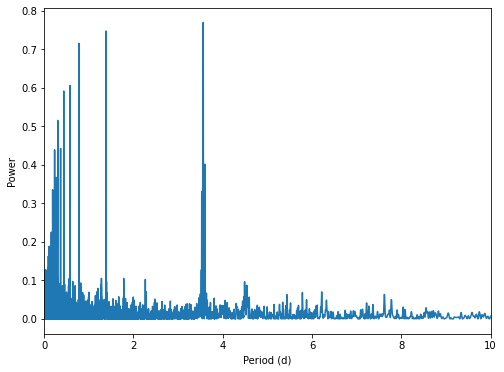

In [38]:
ls = LombScargle(t_obs, mag, error)

frequency, power = ls.autopower(minimum_frequency=1/24, maximum_frequency=50)

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.plot(1/frequency, power)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,10)

maxp = 1/frequency[power.argmax()]
print("Calculated period:", maxp, "days")
print("Compare this to OGLE's result of 3.5635103 days from allGalCep.listID")

>Now looking at the phase folded plot...

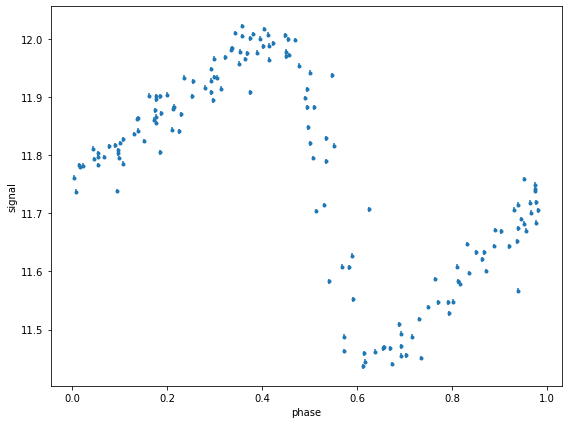

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.errorbar(t_obs / maxp % 1, mag, error, fmt='.')
ax.set_xlabel('phase')
ax.set_ylabel('signal')
fig.tight_layout()

To save on computation time, let's find all files in our OGLE data that are in our dataframe so we don't calculate periods of any stars that we do not have data for.

In [16]:
# Making a list of all the OGLE IDs that we have...
ogleCepheids = [os.path.splitext(file)[0] for file in os.listdir("blg\I") if os.path.isfile(os.path.join("blg\I", file))]
ogleCepheids += [os.path.splitext(file)[0] for file in os.listdir("gd\I") if os.path.isfile(os.path.join("gd\I", file))]

# OGLE IDs in our dataframe...
dfCepheids = mdf["OGLE"].to_list()

# Finding the overlap between the lists...
overlap = [cepheid for cepheid in ogleCepheids if cepheid in dfCepheids]

The function used to calculate the periods:

In [17]:
def get_period(file_path):
    df = convert_to_dataframe(file_path)
    t_obs = df["t_obs"].to_list()
    mag = df["mag"].to_list()
    error = df["error"].to_list()
    ls = LombScargle(t_obs, mag, error)
    # frequency, power = ls.autopower(minimum_frequency=1/3650, maximum_frequency=24)
    frequency, power = ls.autopower(minimum_frequency=1/24, maximum_frequency=50)
    return 1/frequency[power.argmax()]

>I could've actually tried calculating the error in period using the peak width of the LS periodogram... but its getting too late now for me to attempt it and update everything :(

Now we do the actual computation:

In [ ]:
filepaths = ["blg/I/" + file + ".dat" for file in overlap if os.path.isfile("blg/I/" + file + ".dat")]
filepaths += ["gd/I/" + file + ".dat" for file in overlap if os.path.isfile("gd/I/" + file + ".dat")]

d = {'OGLE': overlap, 'period': [get_period(file) for file in filepaths]}
periods = pd.DataFrame(data=d)

# Save so we don't have to keep re-running
periods.to_csv("calculatedPeriods.csv", index=False)

In [19]:
# if we don't need to re-calculate the periods:
periods = pd.read_csv("calculatedPeriods.csv")

And finally combine with our dataframe:

In [20]:
df2 = pd.merge(mdf, periods)
df2

,GaiaEDR3,OGLE,ra,dec,parallax,parallax_error,distance_pc,dist_error,period
0,3330259852538068608,OGLE-GD-CEP-1284,91.856108,11.151976,0.230497,0.021817,4338.444079,410.633183,3.887079
1,3344381567567275392,OGLE-GD-CEP-0028,93.091510,13.636594,0.290342,0.025603,3444.217066,303.714379,3.562779
2,3331279542194394240,OGLE-GD-CEP-0033,96.017277,11.708839,0.230745,0.021257,4333.793904,399.240151,3.181004
3,3327281790934522752,OGLE-GD-CEP-0043,97.720723,9.673099,0.222357,0.017701,4497.274278,358.016914,4.803211
4,3326443821335586816,OGLE-GD-CEP-0046,98.404924,9.203568,0.183142,0.015026,5460.242268,447.976422,4.662567
...,...,...,...,...,...,...,...,...,...
96,4320062347542878208,OGLE-GD-CEP-1544,290.889255,15.367826,0.293404,0.027282,3408.264936,316.920627,0.072772
97,4321755561092593920,OGLE-GD-CEP-1560,292.218457,16.688160,0.281604,0.022221,3551.092158,280.215552,6.049412
98,1825428480248517376,OGLE-GD-CEP-1575,293.565623,19.570660,0.213551,0.018342,4682.717310,402.201849,5.938707
99,1824511899869141120,OGLE-GD-CEP-1580,295.146314,19.285550,0.272804,0.016299,3665.633736,219.010202,1.286318


We also need to add the mean I-band (apparent) magnitude to our dataframe.

In [21]:
def get_mean_I_band(file):
    df = convert_to_dataframe(file)
    mags = df["mag"].to_list()
    return sum(mags)/len(mags)

def get_mean_I_band_err(file):
    df = convert_to_dataframe(file)
    mags = df["mag"].to_list()
    errs = df["error"].to_list()
    return sum(unp.std_devs(unp.uarray(mags, errs)))/len(mags)

In [22]:
df2["Imag"] = [get_mean_I_band(file) for file in filepaths]
df2["ImagErr"] = [get_mean_I_band_err(file) for file in filepaths]

Now we get the extinction using the IRSA Galactic Dust Reddening and Extinction Service.

In [23]:
# Figuring out how to get just one value...
IrsaDust.get_extinction_table(coord.SkyCoord(90.576858*u.deg, 14.331142*u.deg))["A_SandF"][4]

1.494

In [24]:
# make a list of RA, DEC tuples
ra = df2["ra"].to_list()
dec = df2["dec"].to_list()
posns = list(zip(ra, dec))

# make a list of extinction values by fetching the extinction for the CTIO I filter at each RA, DEC position
extinction = [IrsaDust.get_extinction_table(coord.SkyCoord(posn[0]*u.deg, posn[1]*u.deg))["A_SandF"][4] for posn in posns]

In [25]:
# lets add extinction to our dataframe
df2["extinction"] = extinction

Note: the extinction corrected distance modulus solved for absolute magnitude is $$M = m_{\mathrm{obs}} - 5\log_{10}\left(\frac{d}{10\mathrm{pc}}\right) -A$$ where $d$ is the distance in parsecs and $A$ is the extinction term that we got from IRSA (looking at the extinction in the CTIO I filter).

In [26]:
# calculating absolute magnitude
Imag = df2["Imag"].to_list()
ImagErr = df2["ImagErr"].to_list()
dist = df2["distance_pc"].to_list()
distError = df2["dist_error"].to_list()
extinction = df2["extinction"].to_list()
vals = list(zip(Imag, ImagErr, dist, distError, extinction))
df2["AImag"] = [val[0]-5*np.log10(val[2]/10)-val[4] for val in vals]

# calculating error in absolute magnitude
df2["AImagError"] = [unp.std_devs(unc.ufloat(val[0], val[1])-5*unp.log10(unc.ufloat(val[2], val[3])/10)-val[4]) for val in vals]

Now to get a better fit, we do some more filtering. Extinction is calculated for a particular direction out to infinity. Extinction will be particularly high for sources that are in the direction of the galactic bulge. However, since all the sources remaining are close enough to have a parallax error/parallax of less than 0.1, sources in the direction of the galactic bulge will have their extinctions over-estimated. By removing sources that have large extinctions (which are mostly the ones near the direction of the galactic bulge), we can avoid situations with cepheids having absolute magnitudes of less than -10 since they have been over-corrected for extinction.

In [27]:
df3 = df2.loc[(df2["extinction"] < 5)]
df3

,GaiaEDR3,OGLE,ra,dec,parallax,parallax_error,distance_pc,dist_error,period,Imag,ImagErr,extinction,AImag,AImagError
0,3330259852538068608,OGLE-GD-CEP-1284,91.856108,11.151976,0.230497,0.021817,4338.444079,410.633183,3.887079,11.773452,0.004000,0.740,-2.153218,0.20556850900252627
1,3344381567567275392,OGLE-GD-CEP-0028,93.091510,13.636594,0.290342,0.025603,3444.217066,303.714379,3.562779,11.830382,0.004000,1.518,-2.373071,0.1915243040498608
2,3331279542194394240,OGLE-GD-CEP-0033,96.017277,11.708839,0.230745,0.021257,4333.793904,399.240151,3.181004,11.187718,0.004000,1.740,-3.736623,0.2000815660260962
3,3327281790934522752,OGLE-GD-CEP-0043,97.720723,9.673099,0.222357,0.017701,4497.274278,358.016914,4.803211,11.161143,0.004000,2.337,-4.440604,0.17291183561784002
4,3326443821335586816,OGLE-GD-CEP-0046,98.404924,9.203568,0.183142,0.015026,5460.242268,447.976422,4.662567,10.884439,0.004000,1.186,-3.987621,0.17819971225516623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,5337355446425575552,OGLE-GD-CEP-0656,170.054410,-61.504291,0.128687,0.011650,7770.796453,703.476829,5.742793,10.956786,0.004000,4.662,-8.157542,0.19662035169435024
84,5336957839849307520,OGLE-GD-CEP-0657,170.162922,-61.831197,0.231431,0.015830,4320.941577,295.560244,13.364863,11.786728,0.004068,4.982,-6.373164,0.14858834664284637
86,5334864335384747520,OGLE-GD-CEP-0700,176.633794,-61.640995,0.139985,0.011623,7143.646454,593.159489,6.684812,11.809110,0.004000,4.513,-6.973490,0.18034856485651
87,6057402526059795072,OGLE-GD-CEP-0752,181.667633,-62.596845,0.193881,0.011065,5157.791738,294.353012,4.989650,11.211838,0.004000,4.118,-6.468481,0.12398955830425293


Plotting the Period-Luminosity relationship for Cepheids in the Milky Way with its line of best fit:

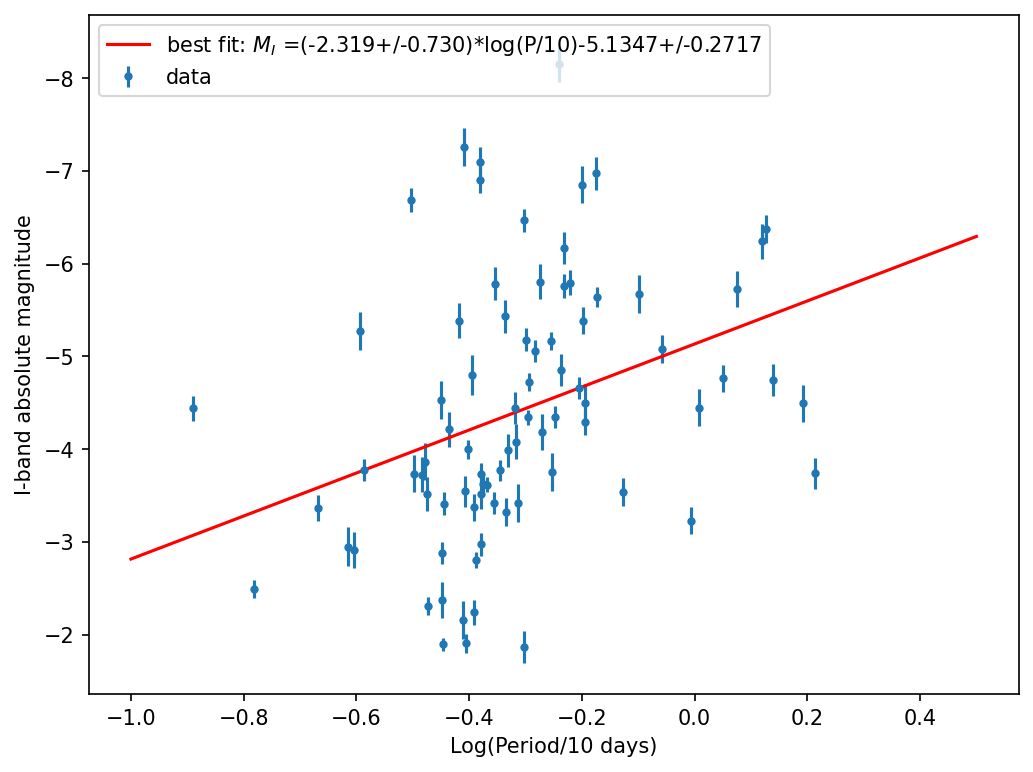

In [28]:
x = df3["period"].to_list()
xlog = [np.log10(i/10) for i in x]
y = df3["AImag"].to_list()
y_err = df3["AImagError"].to_list()

out, cov = np.polyfit(xlog, y, 1, cov=True)
a = out[0]
b = out[1]
outerrs = np.sqrt(np.diag(cov))
aerr = outerrs[0]
berr = outerrs[1]

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.dpi=(150)
d1 = ax.errorbar(xlog, y, y_err, label="data", fmt=".")
l1 = ax.plot(np.linspace(-1, 0.5, 10000), a*np.linspace(-1, 0.5, 10000)+b, color="red", label="best fit: $M_I$ =(" + str(a)[0:6] + "+/-" + str(aerr)[0:5] + ")*log(P/10)" + str(b)[0:7] + "+/-" + str(berr)[0:6])
legend = ax.legend(loc="upper left")
ax.set_ylabel("I-band absolute magnitude")
ax.set_xlabel("Log(Period/10 days)")
ax.invert_yaxis()

Now that we have the Period-Luminosity relationship, we can calculate the distance to cepheids in the LMC.

First we get our data:

In [29]:
# get a list of all LMC cepheids in OGLE that oscillate in the first fundamental mode
LMCCepheids = [os.path.splitext(file)[0] for file in os.listdir("lmc\I") if os.path.isfile(os.path.join("lmc\I", file))]                    # reading in the names of the files from the downloaded data
lmcident = pd.read_fwf("lmcident.dat", colspecs="infer", names=["OGLE", "Mode", "RA", "DEC", "OGLE-IV", "OGLE-III", "OGLE-II", "OtherID"])  # reading in the identifier file that has Mode, RA, and DEC
lmcident1 = (lmcident.loc[(lmcident["Mode"] == "F")])                                                                                       # filtering out LMC cepheids that oscillate in the first fundamental mode
LMCCepheids1 = [v for v in LMCCepheids if v in lmcident1["OGLE"].to_list()]                                                                 # get a list of IDs for the remaining cepheids
LMCfiles = ["lmc/I/" + file + ".dat" for file in LMCCepheids1 if os.path.isfile("lmc/I/" + file + ".dat")]                                  # converting that list of IDs to a list of file paths

# this is to get the mean I-band magnitudes...
lmcdf = pd.read_fwf("lmccepF.dat", colspecs="infer", names=["OGLE", "Imag", "Vmag", "period", "uncertainty", "ToMB", "Iamp", "R_21", "phi_21", "R_31", "phi_31"])

Now, we use LombScargle to calculate the periods of the cepheids within the LMC:

In [ ]:
LMCd = {'OGLE': LMCCepheids1, 
        'period': [get_period(file) for file in LMCfiles]}
LMCperiods = pd.DataFrame(data=LMCd)

# Since this takes a while and won't be different run-to-run, we can just 
# run it once and save the result so we don't need to keep re-calculating
LMCperiods.to_csv("LMCperiods.csv", index=False)

In [31]:
LMCperiods = pd.read_csv("LMCperiods.csv")

Now, we can use the Period-Luminosity relationship to calculate their distance using their extinction corrected apparent I-band magnitudes. To solve for distance, we can use the distance modulus with extinction and solve it for distance. This gives: $$d = 10^{\frac{m_{\mathrm{obs}}-M-A+5}{5}}$$ where $m_{\mathrm{obs}}$ is the observed mean I-band magnitude, $M$ is the calculated absolute magnitude from the period-luminosity relationship, and $A$ is the extinction that we get from IRSA.

In [32]:
lmcMerged0 = pd.merge(LMCperiods, lmcident1, on="OGLE")
lmcMerged = pd.merge(lmcMerged0, lmcdf[["OGLE", "Imag"]], how="inner", on="OGLE")
lmcMerged = lmcMerged.drop([1964]) # I dunno why but this one causes errors

In [ ]:
# make a list of RA, DEC tuples
ra = lmcMerged["RA"].to_list()
dec = lmcMerged["DEC"].to_list()
posns = list(zip(ra, dec))

# make a list of extinction values by fetching the extinction for the CTIO I filter at each RA, DEC position and add that to our dataframe
lmcMerged["Extinction"] = [IrsaDust.get_extinction_table(coord.SkyCoord(posn[0]+posn[1], unit=(u.hourangle, u.deg)))["A_SandF"][4] for posn in posns]

In [123]:
# saving with the extinction
lmcMerged.to_csv("LMCwithExtinction.csv", index=False)

In [34]:
lmcMerged = pd.read_csv("LMCwithExtinction.csv")

In [35]:
# absolute magnitude from period luminosity relationship
lmcMerged["absMag"] = [a*np.log10(i/10)+b for i in lmcMerged["period"].to_list()]           # using my calculated period-luminosity relationship
lmcMerged["absMagErr"] = [unp.std_devs(unc.ufloat(a, aerr)*np.log10(i/10)+unc.ufloat(b, berr)) for i in lmcMerged["period"].to_list()]  # trying to get the error in the absolute magnitude

In [36]:
# now finding the distance (using my PL relationship)
ins = list(zip(lmcMerged["Imag"].to_list(), lmcMerged["absMag"].to_list(), lmcMerged["Extinction"].to_list(), lmcMerged["absMagErr"].to_list()))
lmcMerged["distance_pc"] = [10**((float(i[0])-float(i[1])-float(i[2])+5)/5) for i in ins]
lmcMerged["distance_pc_err"] = [unp.std_devs(10**( (float(i[0]) - unc.ufloat(i[1], i[3]) - float(i[2]) + 5)/5 )) for i in ins]


Finally, we can calculate the average distance to the LMC by averaging over the distances to all the cepheids within the LMC.

Distance to LMC: 52165.867570987866 +/- 10270.212804543027 pc 
Actual distance: ~40-55 kpc 


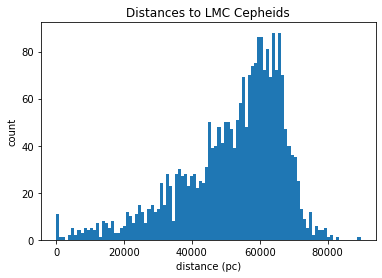

In [37]:
# average (my PL)
distances = lmcMerged["distance_pc"].to_list()
distance_errors = lmcMerged["distance_pc_err"].to_list()
averageDistLMC = sum(distances)/len(distances)
avgDistLMCErr = sum(unp.std_devs(unp.uarray(distances, distance_errors)))/len(distances)

# plot histogram of calculated distances
fig, ax = plt.subplots()
ax.hist(distances, bins=100)
ax.set_xlabel("distance (pc)")
ax.set_ylabel("count")
ax.set_title("Distances to LMC Cepheids")

# printing results
print("Distance to LMC:", averageDistLMC, "+/-", avgDistLMCErr, "pc", "\nActual distance: ~40-55 kpc ")

___